In [1]:
from py_functions import plot_training_history, focal_loss
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras.metrics import Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

os.environ['CUDA_VISIBLE_DEVICES'] = ''

2026-01-01 15:35:52.662973: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-01 15:35:52.671480: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-01 15:35:52.935614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-01 15:35:54.059341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

# Data loading

In [3]:
# Load X data ========================
vst_min_max = pd.read_csv("InputTables/Input_TCGA-BEAT_top3000_vst_min_max.txt", 
                          sep="\t", header=0)
Fischer_vst_min_max = pd.read_csv("InputTables/Input_Fischer_top3000_vst_min_max_ComBat.txt", 
                                  sep="\t", header=0)
Fischer_vst_min_max.columns = Fischer_vst_min_max.columns.str.replace('.', '-', regex=False)

# Check if columns are identical
assert list(Fischer_vst_min_max.columns) == list(vst_min_max.columns), "Column names do not match!"

# Load y data ========================
TCGA_BEAT_labels_df = pd.read_csv("InputTables/TCGA_BEAT_labels_FLT3_ITD.txt", 
                                  sep="\t", header=0)
TCGA_BEAT_labels = TCGA_BEAT_labels_df['x'].tolist()

Fischer_labels_df = pd.read_csv("InputTables/Fischer_labels_FLT3_ITD.txt", 
                                sep="\t", header=0)
Fischer_labels = pd.Categorical(Fischer_labels_df['label'])

# Load partition indexes ========================
train_index = np.loadtxt("InputTables/Input_train_indexes.txt", dtype=int)

# Convert R's 1-based indices to 0-based indices
train_index = train_index - 1

# ======================== Split data ========================
y_train = pd.Categorical([TCGA_BEAT_labels[i] for i in train_index])
y_test = pd.Categorical([TCGA_BEAT_labels[i] for i in range(len(TCGA_BEAT_labels)) if i not in train_index])

x_train_vst_min_max = vst_min_max.iloc[train_index, :]

all_indices = np.arange(len(vst_min_max))
test_index = np.setdiff1d(all_indices, train_index)

x_test_vst_min_max = vst_min_max.iloc[test_index, :]


# Prepare data

In [4]:
# Convert categorical labels to integers
le = LabelEncoder()
le.classes_ = np.array(["FLT3_ITD.WT", "FLT3_ITD.Mutant"])
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)
Fischer_labels_encoded = le.transform(Fischer_labels)

# Check mapping
for i, cls in enumerate(le.classes_):
    print(f"Class {cls}: {i}")

Class FLT3_ITD.WT: 0
Class FLT3_ITD.Mutant: 1


# Handle class imbalance 

In [5]:
smote = SMOTE(random_state=12345)
x_train_smote, y_train_smote = smote.fit_resample(x_train_vst_min_max, y_train_encoded)

# Build FCNN

In [6]:
model_dropout_03 = Sequential([
    Dense(128, activation='relu', input_shape=(x_train_vst_min_max.shape[1],), name='hidden_layer_1'),
    Dropout(0.2, name='dropout_1'),
    Dense(64, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    # Dense(64, activation='relu', name='hidden_layer_3'),
    # Dropout(0.2, name='dropout_3'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# Define optimizer
optimizer = Adam(learning_rate=1e-5)

# Compile model
model_dropout_03.compile(optimizer=optimizer,
              loss=focal_loss,
              metrics=[Recall(name="sensitivity")])

# Show summary
model_dropout_03.summary()

/venv/cohANN/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-01 15:38:50.067410: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │       384,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,449 (1.50 MB)

 Trainable params: 392,449 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

# Define Early Stopping

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Train model

Set random seeds

In [8]:
random.seed(12345)
np.random.seed(12345)
tensorflow.random.set_seed(12345)

In [9]:
history = model_dropout_03.fit(
    x_train_smote,
    y_train_smote,
    validation_data=(x_test_vst_min_max, y_test_encoded),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0883 - sensitivity: 0.2471 - val_loss: 0.0595 - val_sensitivity: 0.0000e+00
Epoch 2/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0753 - sensitivity: 0.0776 - val_loss: 0.0586 - val_sensitivity: 0.0000e+00
Epoch 3/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0719 - sensitivity: 0.1318 - val_loss: 0.0592 - val_sensitivity: 0.0408
Epoch 4/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0703 - sensitivity: 0.1671 - val_loss: 0.0559 - val_sensitivity: 0.0408
Epoch 5/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0659 - sensitivity: 0.1788 - val_loss: 0.0562 - val_sensitivity: 0.0816
Epoch 6/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0666 - sensitivity: 0.2118 - val_loss: 0.0533 - val_sensitivity: 0.1633
Epoch 7/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0645 - sensitivity: 0.2518 - val_loss: 0.0517 - val_sensitivity: 0.1837
Epoch 8/1000
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

# Evaluate the model


Test Accuracy: 0.5714
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
                 precision    recall  f1-score   support

    FLT3_ITD.WT       0.90      0.98      0.94       188
FLT3_ITD.Mutant       0.90      0.57      0.70        49

       accuracy                           0.90       237
      macro avg       0.90      0.78      0.82       237
   weighted avg       0.90      0.90      0.89       237

Confusion Matrix:
[[185   3]
 [ 21  28]]


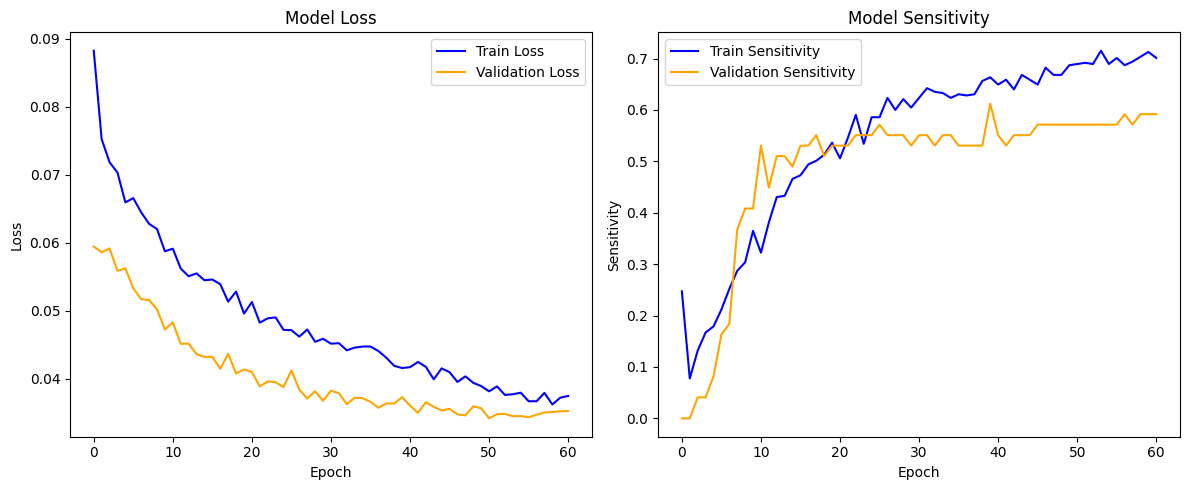

In [11]:
test_loss, test_acc = model_dropout_03.evaluate(x_test_vst_min_max, y_test_encoded, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions
threshold = 0.5
y_pred_prob = model_dropout_03.predict(x_test_vst_min_max)
y_pred = (y_pred_prob >= threshold).astype(int)

# Classification report & confusion matrix
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=["FLT3_ITD.WT", "FLT3_ITD.Mutant"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))
plot_training_history(history)

## Lowering the threshold

In [29]:
test_loss, test_acc = model_dropout_03.evaluate(x_test_vst_min_max, y_test_encoded, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Predictions
threshold = 0.3
y_pred_prob = model_dropout_03.predict(x_test_vst_min_max)
y_pred = (y_pred_prob >= threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=["FLT3_ITD.WT", "FLT3_ITD.Mutant"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))


Test Accuracy: 0.5714
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report:
                 precision    recall  f1-score   support

    FLT3_ITD.WT       0.95      0.67      0.79       188
FLT3_ITD.Mutant       0.41      0.88      0.56        49

       accuracy                           0.71       237
      macro avg       0.68      0.77      0.67       237
   weighted avg       0.84      0.71      0.74       237

Confusion Matrix:
[[126  62]
 [  6  43]]


# Save model

In [ ]:
model_dropout_03.save("OutputTables/fcnn_model_FLT3_ITD_3L_dropout02.keras")

# Test on Fischer data

In [30]:
model = keras.models.load_model("OutputTables/fcnn_model_FLT3_ITD_3L_dropout02.keras")

# Predictions
y_pred_prob = model.predict(Fischer_vst_min_max)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(Fischer_labels_encoded, y_pred, target_names=["FLT3_ITD.WT", "FLT3_ITD.Mutant"]))
print("Confusion Matrix:")
print(confusion_matrix(Fischer_labels_encoded, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Classification Report:
                 precision    recall  f1-score   support

    FLT3_ITD.WT       0.76      0.96      0.85        26
FLT3_ITD.Mutant       0.92      0.60      0.73        20

       accuracy                           0.80        46
      macro avg       0.84      0.78      0.79        46
   weighted avg       0.83      0.80      0.80        46

Confusion Matrix:
[[25  1]
 [ 8 12]]


## Lowering the threshold

In [31]:
model = keras.models.load_model("OutputTables/fcnn_model_FLT3_ITD_3L_dropout02.keras")

# Predictions
y_pred_prob = model.predict(Fischer_vst_min_max)
y_pred = (y_pred_prob >= 0.3).astype(int)

print("\nClassification Report:")
print(classification_report(Fischer_labels_encoded, y_pred, target_names=["FLT3_ITD.WT", "FLT3_ITD.Mutant"]))
print("Confusion Matrix:")
print(confusion_matrix(Fischer_labels_encoded, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Classification Report:
                 precision    recall  f1-score   support

    FLT3_ITD.WT       0.96      0.85      0.90        26
FLT3_ITD.Mutant       0.83      0.95      0.88        20

       accuracy                           0.89        46
      macro avg       0.89      0.90      0.89        46
   weighted avg       0.90      0.89      0.89        46

Confusion Matrix:
[[22  4]
 [ 1 19]]


# Choosing the best threshold

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


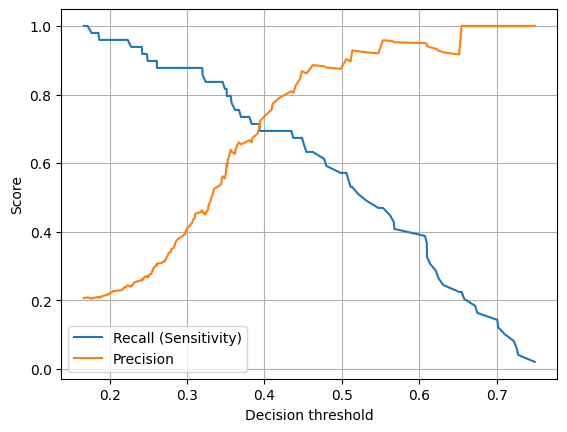

In [32]:
from sklearn.metrics import precision_recall_curve

model = keras.models.load_model("OutputTables/fcnn_model_FLT3_ITD_3L_dropout02.keras")

y_pred_prob = model.predict(x_test_vst_min_max)
y_pred = (y_pred_prob >= 0.5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test_encoded, y_pred_prob)

plt.figure()
plt.plot(thresholds, recall[:-1], label="Recall (Sensitivity)")
plt.plot(thresholds, precision[:-1], label="Precision")
plt.xlabel("Decision threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
y_pred = (y_pred_prob >= 0.34).astype(int)

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=["FLT3_ITD.WT", "FLT3_ITD.Mutant"]))
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))


Classification Report:
                 precision    recall  f1-score   support

    FLT3_ITD.WT       0.95      0.81      0.87       188
FLT3_ITD.Mutant       0.53      0.84      0.65        49

       accuracy                           0.81       237
      macro avg       0.74      0.82      0.76       237
   weighted avg       0.86      0.81      0.83       237

Confusion Matrix:
[[152  36]
 [  8  41]]


## Test new thresholds on Fischer

In [41]:
Fischer_pred_prob = model.predict(Fischer_vst_min_max)
Fischer_pred = (Fischer_pred_prob >= 0.34).astype(int)

print("\nClassification Report:")
print(classification_report(Fischer_labels_encoded, Fischer_pred, target_names=["FLT3_ITD.WT", "FLT3_ITD.Mutant"]))
print("Confusion Matrix:")
print(confusion_matrix(Fischer_labels_encoded, Fischer_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Classification Report:
                 precision    recall  f1-score   support

    FLT3_ITD.WT       0.85      0.88      0.87        26
FLT3_ITD.Mutant       0.84      0.80      0.82        20

       accuracy                           0.85        46
      macro avg       0.85      0.84      0.84        46
   weighted avg       0.85      0.85      0.85        46

Confusion Matrix:
[[23  3]
 [ 4 16]]


In [42]:
Fischer_pred_prob = model.predict(Fischer_vst_min_max)
Fischer_pred = (Fischer_pred_prob >= 0.3).astype(int)

print("\nClassification Report:")
print(classification_report(Fischer_labels_encoded, Fischer_pred, target_names=["FLT3_ITD.WT", "FLT3_ITD.Mutant"]))
print("Confusion Matrix:")
print(confusion_matrix(Fischer_labels_encoded, Fischer_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Classification Report:
                 precision    recall  f1-score   support

    FLT3_ITD.WT       0.96      0.85      0.90        26
FLT3_ITD.Mutant       0.83      0.95      0.88        20

       accuracy                           0.89        46
      macro avg       0.89      0.90      0.89        46
   weighted avg       0.90      0.89      0.89        46

Confusion Matrix:
[[22  4]
 [ 1 19]]


# Cross-validaton

In [43]:
from sklearn.model_selection import StratifiedKFold

random.seed(12345)
np.random.seed(12345)
tensorflow.random.set_seed(12345)

X = x_train_vst_min_max
y = y_train_encoded

kf = StratifiedKFold(n_splits=15, shuffle=True, random_state=12345)
scores = []

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

best_sensitivity = 0
best_model = None

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Apply SMOTE
    smote = SMOTE(random_state=12345)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Build FCNN for each fold fold
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(1e-5),
                  loss=focal_loss,
                  metrics=[Recall(name="sensitivity")])
    
    model.fit(X_train, y_train, epochs=1000, batch_size=32,
              callbacks=[early_stop], verbose=0)
    
    score = model.evaluate(X_val, y_val, verbose=0)
    scores.append(score[1])
    sensitivity = score[1]

    if sensitivity > best_sensitivity:
        best_sensitivity = sensitivity
        best_model = keras.models.clone_model(model)
        best_model.set_weights(model.get_weights())

print("CV scores:", scores)
print("Mean CV score:", np.mean(scores))

/venv/cohANN/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/venv/cohANN/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,sensitivity
  current = self.get_monitor_value(logs)
/venv/cohANN/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/venv/cohANN/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:99

CV scores: [0.625, 0.625, 0.5, 0.875, 0.625, 0.5555555820465088, 0.4444444477558136, 0.5555555820465088, 0.4444444477558136, 0.4444444477558136, 0.5555555820465088, 0.7777777910232544, 0.6666666865348816, 0.6666666865348816, 0.75]
Mean CV score: 0.607407416899999
